In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import folium
import time
import warnings
import pickle
import sys
warnings.filterwarnings('ignore')
print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../models')
sys.path.append('../visualization')
# import modules
import visualize
from maritime_traffic_network import MaritimeTrafficNetwork

In [3]:
datasize = 'full'
location = 'tromso'
data_date = '202204'
eval_date = '202206'

# load network from pickle
model = data_date+'_waypoints_DP10_HDBSCAN12_'+location+'_'+datasize+'_UTM'
model_path = '../../models/networks/best_networks/' + model + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_tromso_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 12,
 'clustering_min_cluster_size': 12,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.e+00, 0.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 1.e+00, 0.e+00, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 1.e-02, 0.e+00, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 1.e-02, 0.e+00],
        [0.e+00, 0.e+00, 0.e+00, 0.e+00, 5.e-04]]),
 'graph_generation_max_distance': 10,
 'graph_generation_max_angle': 45}

In [4]:
# load evaluation data
eval_file = eval_date+'_points_'+location+'_cleaned_meta_full_dualSplit_2'
filename = '../../data/processed/' + eval_file + '.parquet'
test_gdf = gpd.read_parquet(filename)
crs = 32632  # Coordinate reference system
test_gdf.to_crs(crs, inplace=True)  # Transformation
all_test_trajectories = mpd.TrajectoryCollection(test_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

# select evaluation data
selection_start = 0
selection_end = len(all_test_trajectories)
selection_step = 1
selection = np.arange(selection_start, selection_end, selection_step)
n_trajectories = len(selection)
mmsis = test_gdf.mmsi.unique()[selection]
test_trajectories = all_test_trajectories.filter('mmsi', mmsis.tolist())

In [5]:
# merge stop points
network.merge_stop_points(max_speed=2)
network.prune_graph(1)

Pruning...
------------------------
Pruned Graph:
Number of nodes: 565 (1 isolated)
Number of edges: 2181
------------------------


Evaluating graph on 1822 trajectories
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done! Time elapsed for evaluation: 29.19 minutes
Success rates:
                   mmsi      SSPD  distances  fraction_covered      path  path_linestring
message                                                                                  
attempt        0.023052  0.023052   0.023052          0.023052  0.023052         0.023052
no_intersects  0.139407  0.000000   0.000000          0.139407  0.000000         0.000000
no_path        0.002195  0.000000   0.000000          0.002195  0.000000         0.000000
success        0.835346  0.835346   0.835346          0.835346  0.835346         0.835346

 --------------------------- 

Fraction of NaN results: 0.142

 --------------------------- 

Mean fraction of each trajectory covered by the path on the graph: 0.900 

Mean distance      = 132.09 m
Median distance    = 75.58 m
Standard deviation = 341.60 m 



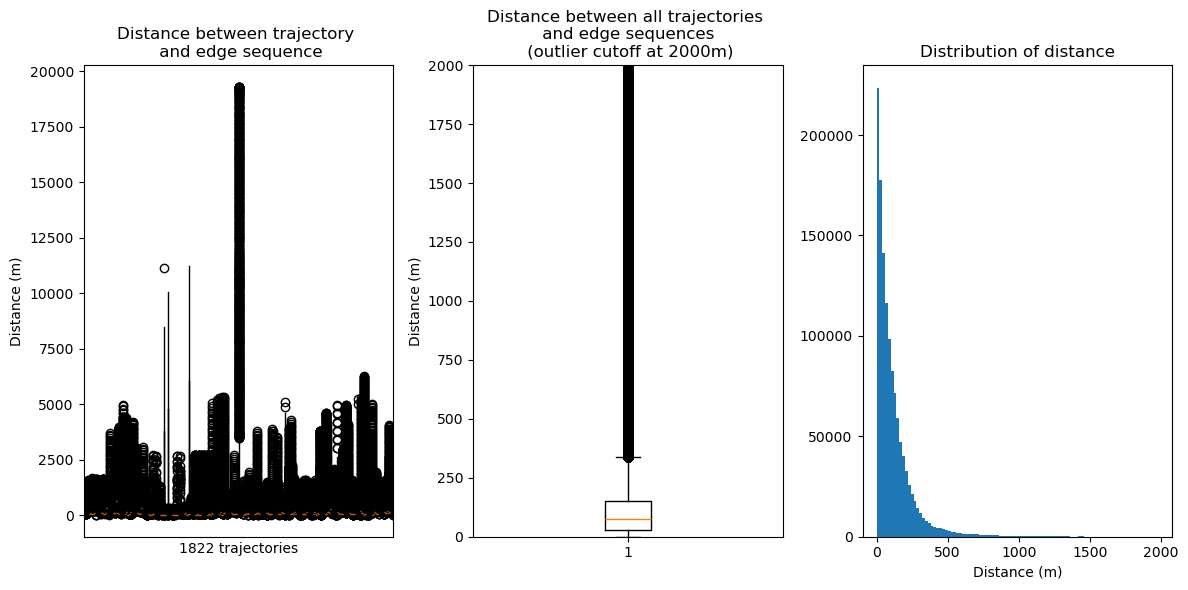

In [6]:
# evaluate all trajectories on the current network to create a training dataset for this specific network
all_paths, all_evaluation_results, summary, fig = network.evaluate_graph(test_trajectories)

In [7]:
all_evaluation_results

,mmsi,SSPD,distances,fraction_covered,message,path,path_linestring
0,210055000_0_2022-06-01 09:31:46,132.679319,"[102.38048145704865, 110.45856414169168, 114.8...",1.000000,success,"[143, 141, 2, 356, 355, 349, 346, 471, 484, 49...",LINESTRING (856512.7976157027 7729254.12696144...
0,210055000_8_2022-06-01 20:12:01,69.754691,"[10.140162010288114, 4.9800642928975885, 0.140...",0.969632,success,"[529, 527, 516, 515, 514, 502, 371, 503, 508, ...",LINESTRING (885753.6360268057 7758504.10757204...
0,210189000_0_2022-06-24 06:55:42,131.187229,"[41.40497947011437, 38.613020638855, 30.521691...",0.981730,success,"[207, 202, 200, 199, 250, 249, 235, 256, 285, ...",LINESTRING (842910.9678971029 7748203.73867224...
0,210189000_100_2022-06-30 09:45:31,63.989376,"[7.002395107157489, 6.946466322983776, 6.89110...",0.984347,success,"[486, 485, 480, 28, 475, 470, 465, 473, 474, 4...",LINESTRING (885710.2144157992 7758389.11390295...
0,210189000_8_2022-06-25 16:12:16,10.643908,"[15.300550609750253, 15.866289543654108, 19.76...",0.601007,success,"[487, 486, 485, 28]",LINESTRING (885634.3387234658 7758197.40048689...
...,...,...,...,...,...,...,...
0,319139200_0_2022-06-10 14:50:38,54.688208,"[58.85519245224754, 59.17261516483973, 61.3616...",0.219866,success,"[207, 202]",LINESTRING (842910.9678971029 7748203.73867224...
0,319139200_30_2022-06-11 16:52:42,135.007247,"[110.27872101703873, 91.71312650793726, 77.093...",0.308680,success,"[194, 192]",LINESTRING (844471.8875836682 7746645.35311776...
0,319139200_31_2022-06-11 18:45:23,NaN,NaN,0.000000,no_intersects,NaN,NaN
0,319139200_32_2022-06-13 00:49:11,NaN,NaN,0.000000,no_intersects,NaN,NaN


In [8]:
df = all_evaluation_results

In [9]:
# Filter out NaN results and bad examples
nan_mask = df.isna().any(axis=1)
df = df[~nan_mask]
#df = df[df['fraction_covered']>0.8]
#df = df[df['SSPD']<300]

In [10]:
# merge results with trajectory data and metadata
test_trajectories = test_trajectories.filter('mmsi', df['mmsi'].tolist())
traj_gdf = test_trajectories.to_traj_gdf()
merge_columns = ['mmsi', 'lengde', 'bredde', 'dypgaaende', 'skipstype', 'skipsgruppe']
test_gdf.drop_duplicates(subset=['mmsi'], inplace=True)
test_gdf.rename(columns={'length': 'lengde'}, inplace=True)
traj_gdf = traj_gdf.merge(test_gdf[merge_columns], on='mmsi', how='left')

merge_columns = ['mmsi', 'lengde', 'bredde', 'dypgaaende', 'skipstype', 'skipsgruppe', 'geometry']
df = df.merge(traj_gdf[merge_columns], on='mmsi', how='left')
df = gpd.GeoDataFrame(df)

In [11]:
df.to_csv(model+'_'+eval_date+'training_data.csv')

In [12]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1564 entries, 0 to 1563
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   mmsi              1564 non-null   object  
 1   SSPD              1564 non-null   float64 
 2   distances         1564 non-null   object  
 3   fraction_covered  1564 non-null   float64 
 4   message           1564 non-null   object  
 5   path              1564 non-null   object  
 6   path_linestring   1564 non-null   object  
 7   lengde            1564 non-null   int64   
 8   bredde            1156 non-null   float64 
 9   dypgaaende        1063 non-null   float64 
 10  skipstype         1158 non-null   object  
 11  skipsgruppe       1158 non-null   object  
 12  geometry          1564 non-null   geometry
dtypes: float64(4), geometry(1), int64(1), object(7)
memory usage: 159.0+ KB
